In [1]:
import numpy as np
from scipy.ndimage import rotate
import os
from PIL import Image
import math
import cv2 as cv
import matplotlib.pyplot as plt

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import cv2
import numpy as np
import skimage
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

%matplotlib inline
from google.colab import files
files.upload()
from exGenerator import *
matricola = '1962169'



#Load

In [2]:
im1, im2, im3, im4 = ex11(matricola)

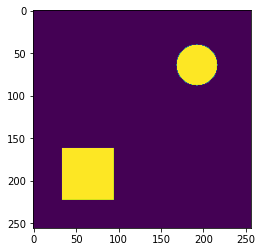

In [3]:
plt.imshow(im1)

In [4]:
im1.save("output.png", "PNG")
im1.save("frame1.png", "PNG")
im2.save("frame2.png", "PNG")

In [5]:
frame1 = np.matrix(im1)
frame2 = np.matrix(im2)
frame3 = np.matrix(im3)

fig, axes = plt.subplots(ncols=3, figsize=(im1.height, im1.width), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(frame1)
ax[0].set_title('frame1')
ax[1].imshow(frame2)
ax[1].set_title('frame2')
ax[2].imshow(frame3)
ax[2].set_title('frame3')


Text(0.5, 1.0, 'frame3')

#Segmentation

Text(0.5, 1.0, 'Separated objects (See Red)')

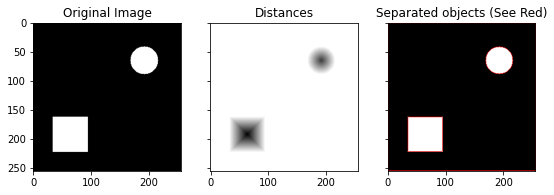

In [6]:
original = cv.imread("output.png")

img = original

original = cv2.cvtColor(original,cv2.COLOR_BGR2RGB)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

ret, thresh = cv.threshold(gray,120,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
thresh = 255 - thresh

# Remove noise
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

# background area
background = cv.dilate(opening,kernel,iterations=3)

# Finding foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, foreground = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
foreground = np.uint8(foreground)
unknown = cv.subtract(background,foreground)

# UNKNOW = 0
# So, i change the value of background array to avoid the error of consider it as unknown. I marked it with different integer, instead i marked the unknown with 0
ret, markers = cv.connectedComponents(foreground)
markers = markers+1

# Set the unknown with zero
markers[unknown==255] = 0

# Apply the watershed and all the boundary regions will be markes as -1
markers = cv.watershed(img,markers)

img[markers == -1] = [0,0,255] #RED

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

ax[0].imshow(original, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[1].imshow(-dist_transform, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(img, cmap=plt.cm.gray)
ax[2].set_title('Separated objects (See Red)')


#Optical Flow

In [7]:
def plot_quiver(ax, flow, spacing, margin=0, **kwargs):
    """Plots less dense quiver field.

    Args:
        ax: Matplotlib axis
        flow: motion vectors
        spacing: space (px) between each arrow in grid
        margin: width (px) of enclosing region without arrows
        kwargs: quiver kwargs (default: angles="xy", scale_units="xy")
    """
    h, w, *_ = flow.shape

    nx = int((w - 2 * margin) / spacing)
    ny = int((h - 2 * margin) / spacing)

    x = np.linspace(margin, w - margin - 1, nx, dtype=np.int64)
    y = np.linspace(margin, h - margin - 1, ny, dtype=np.int64)

    flow = flow[np.ix_(y, x)]
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    kwargs = {**dict(angles="xy", scale_units="xy"), **kwargs}
    ax.quiver(x, y, u, v, **kwargs)

    ax.set_ylim(sorted(ax.get_ylim(), reverse=True))
    ax.set_aspect("equal")


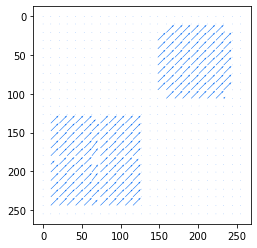

In [8]:
in_frame1 = cv.imread("frame1.png")
in_frame2 = cv.imread("frame2.png")
gray_1 = cv.cvtColor(in_frame1,cv.COLOR_BGR2GRAY)
gray_2 = cv.cvtColor(in_frame2,cv.COLOR_BGR2GRAY)

flow = cv.calcOpticalFlowFarneback(frame1,frame2,None, 0.5, 3, 50, 5, 5, 1.2, 0)

fig, ax = plt.subplots()
plot_quiver(ax, flow, spacing=10, scale=1, color="#0069F5")
